In [21]:
import itertools
import joblib
import pickle 
import random

import networkx as nx
import numpy as np
import pandas as pd
import cvxpy as cp

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from pgmpy import inference

import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

import scipy.optimize as optimize
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import wasserstein_distance
from scipy.optimize import linprog
from scipy import stats

from collections import Counter
from IPython.utils import io
from cvxpy.error import SolverError
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from itertools import chain, combinations

import maps
from src.examples import smokingmodels as sm
import modularized_utils as ut
import cost_functions_utils as cts
import classes as cls
import params

np.random.seed(0)
np.set_printoptions(precision=4,suppress=True)

## Import the Structural Causal Models

In [22]:
M_base = sm.M_chain_STC_t
M_abst = sm.M_chain_ST_a  

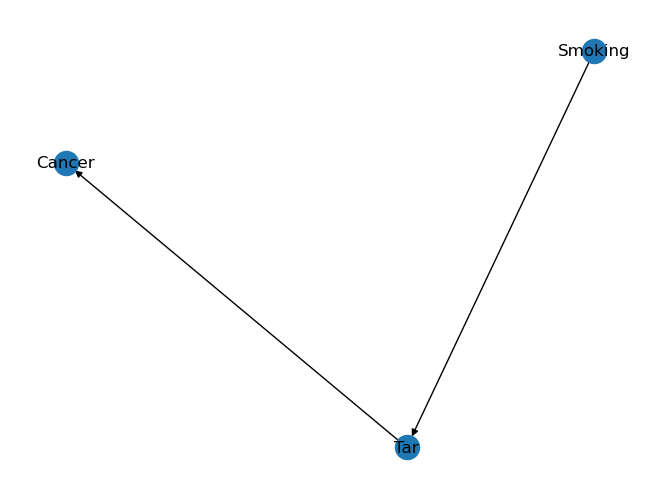

In [23]:
nx.draw(nx.DiGraph(M_base.edges()),with_labels=True)

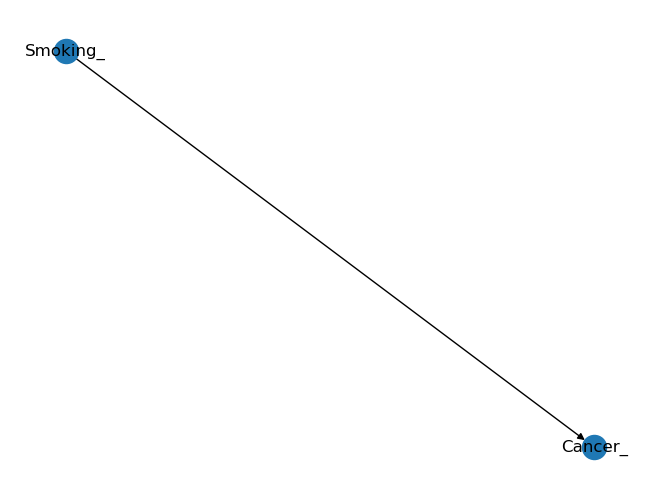

In [24]:
nx.draw(nx.DiGraph(M_abst.edges()),with_labels=True)

## Define the sets of (relevant) interventions

In [25]:
iota0 = cls.Intervention(M_base, {None: None})

iota1 = cls.Intervention(M_base, {'Tar': 0})

iota3 = cls.Intervention(M_base, {'Tar': 1})

iota0_prime = cls.Intervention(M_abst, {None: None})
iota1_prime = cls.Intervention(M_abst, {'Cancer_': 0})
iota2_prime = cls.Intervention(M_abst, {'Cancer_': 1})

## Define the (total) surjective and order-preserving function $ω:I_{base} \mapsto I_{abst}$

In [26]:
omega = {   
            iota0: iota0_prime,
            iota1: iota1_prime,
            iota3: iota2_prime
        }

I_relevant = list(omega.keys())

In [27]:
joblib.dump(M_base,'data/synth1T/M_base.pkl')
joblib.dump(M_abst,'data/synth1T/M_abst.pkl')
joblib.dump(omega,'data/synth1T/omega.pkl')

['data/synth1T/omega.pkl']

## Create the set of pairs $Π_ω(I)$

$$\Pi_{\omega}(\mathcal{I})=\{\pi_i : i=1,...,|\mathcal{I}|\}$$

where $\forall i \in \mathcal{I} : \pi_i = (\pi_{i,s},\pi_{i,t})=(P_{M_i}(\mathcal{X}), P_{M'_{\omega(i)}}(\mathcal{Y}))$.

Note, that $\pi_{i,s}$ expresses the source distribution and $\pi_{i,t}$ the target distribution of the $i$-th pair.

In [28]:
n_simuls   = params.n_simuls['synth1T']
n_samples  = params.n_samples['synth1T']

In [29]:
pairs = []
for n in range(n_simuls):
    ps = ut.create_pairs(100000, I_relevant, omega, M_base, M_abst)
    pairs.append(ps)

In [30]:
joblib.dump(pairs,'data/synth1T/pairs.pkl')

['data/synth1T/pairs.pkl']

# Pairs Shuffling

In [33]:
base_list = list(pairs[0][0].base_dict.keys())
abst_list = list(pairs[0][0].abst_dict.keys())

random.shuffle(base_list)
random.shuffle(abst_list)

for n in range(n_simuls):
    for pair in pairs[n]:
        
        pair.base_labels = base_list
        pair.abst_labels = abst_list
        
        pair.base_dict = {key: pair.base_dict[key] for key in base_list}
        pair.abst_dict = {key: pair.abst_dict[key] for key in abst_list}
        
        pair.base_distribution = list(pair.base_dict.values())
        pair.abst_distribution = list(pair.abst_dict.values())

In [34]:
joblib.dump(pairs,'data/synth1T/shufpairs.pkl')

['data/synth1T/shufpairs.pkl']